In [2]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 57.9 MB/s eta 0:00:00


In [3]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Define the Q matrix
Q = np.array([
    [-9, 5, 5],
    [5, -6, 5],
    [5, 5, 5]
])


In [5]:
# Number of qubits
n_qubits = Q.shape[0]
wires = range(n_qubits)

# Translate QUBO to cost Hamiltonian
coeffs = []
ops = []

for i in range(n_qubits):
    coeffs.append(Q[i, i] / 2)
    ops.append(qml.PauliZ(i))
    for j in range(i + 1, n_qubits):
        coeffs.append(Q[i, j] / 4)
        ops.append(qml.PauliZ(i) @ qml.PauliZ(j))

cost_h = qml.Hamiltonian(coeffs, ops)
print("Cost Hamiltonian:")
print(cost_h)

Cost Hamiltonian:
-4.5 * Z(0) + 1.25 * (Z(0) @ Z(1)) + 1.25 * (Z(0) @ Z(2)) + -3.0 * Z(1) + 1.25 * (Z(1) @ Z(2)) + 2.5 * Z(2)


In [7]:
# Define mixer Hamiltonian (standard X mixer)
mixer_coeffs = [1 for _ in range(n_qubits)]
mixer_ops = [qml.PauliX(i) for i in range(n_qubits)]
mixer_h = qml.Hamiltonian(mixer_coeffs, mixer_ops)

print("\nMixer Hamiltonian:")
print(mixer_h)


Mixer Hamiltonian:
1 * X(0) + 1 * X(1) + 1 * X(2)


In [11]:
# QAOA layer
def qaoa_layer(gamma, alpha):
    qml.qaoa.cost_layer(gamma, cost_h) # Use qml.qaoa to access cost_layer and mixer_layer
    qml.qaoa.mixer_layer(alpha, mixer_h)

# Circuit
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

# Define device
dev = qml.device("default.qubit", wires=n_qubits)

In [12]:
# Cost function
@qml.qnode(dev)
def cost_fn(params):
    circuit(params)
    return qml.expval(cost_h)


In [13]:
# Optimize
opt = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

for i in range(steps):
    params = opt.step(cost_fn, params)

print("\nOptimal Parameters:")
print(params)


Optimal Parameters:
[[-0.00121012  0.92617731]
 [ 1.07467853  1.0290333 ]]


In [14]:
# Get final probabilities
@qml.qnode(dev)
def prob_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = prob_circuit(params[0], params[1])

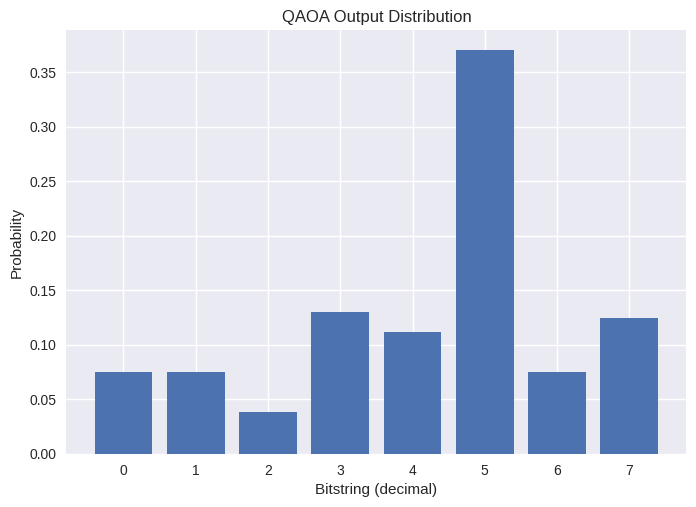

In [15]:
# Plot
plt.style.use("seaborn-v0_8")
plt.bar(range(2 ** n_qubits), probs)
plt.xlabel("Bitstring (decimal)")
plt.ylabel("Probability")
plt.title("QAOA Output Distribution")
plt.show()